In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from cycler import cycler

mpl.rcParams.update({'font.size': 18})
plt.rcParams['axes.axisbelow'] = True

## seed of random number
random_seed = int(time.time())
## initialization of random number generator
np.random.seed(random_seed)

from sklearn.model_selection import train_test_split


### Previa: Cómo funciona Qulacs?

#### Definición de estados

In [2]:
from qulacs import QuantumState

# Opciones
n = 3
state = QuantumState(n)
# Initialize as |0> state
state.set_zero_state()
print('0 state vector: ', state.get_vector())

# Initialize the specified value to the calculation base in binary notation
state.set_computational_basis(0b111)
print('down up down state vector: ', state.get_vector())

# Initialize to random pure state with Haar measure using argument value as seed
# If no value is specified, the time function is used as a seed. Pseudo random number uses xorshift.
state.set_Haar_random_state(0)
print('Random Haar state: ', state.get_vector())

# Transform between quantum state and list
state = QuantumState(2)
state.load([0,1,2,3])
print('From list: ', state.get_vector())


0 state vector:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
down up down state vector:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
Random Haar state:  [-0.08457288-0.14143014j -0.13386446+0.11328032j -0.22521966-0.16546737j
 -0.15105932+0.48125064j -0.45087363+0.17271267j -0.05855838+0.32498025j
  0.35972119+0.02643361j -0.10103482-0.35651694j]
From list:  [0.+0.j 1.+0.j 2.+0.j 3.+0.j]


Estudiamos los estados /1> y /N> de la base computacional para un sistema de 4 qubits

In [3]:
nqubit = 4

In [4]:
from qulacs.state import inner_product

state1 = QuantumState(nqubit)
nstate = QuantumState(nqubit)

state1.set_computational_basis(0b0001)
nstate.set_computational_basis(0b1000)
print('state 1: ',  state1.get_vector())
print('Tiene el elemento 1 distinto de 0: ', state1.get_vector()[1] != 0)
print('state n: ',  nstate.get_vector())
print('Tiene el elemento 8 distinto de 0: ', nstate.get_vector()[8] != 0)

state 1:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Tiene el elemento 1 distinto de 0:  True
state n:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Tiene el elemento 8 distinto de 0:  True


Defino una función para medir los valores de expectación en Z para un estado

In [5]:
from qulacs import Observable

def measure_exp_vals(state):
    nqubit = state.get_qubit_count()
    for i in range(nqubit):
        z = Observable(nqubit)
        z.add_operator(1.,'Z ' + str(i))
        print(f' Z_{i} =  {z.get_expectation_value(state)}')
        
print('Valores de expectación asociados al estado |1>')
print('--------------------------------------------')
measure_exp_vals(state1)
print('Valores de expectación asociados al estado |N>')
print('--------------------------------------------')
measure_exp_vals(nstate)


Valores de expectación asociados al estado |1>
--------------------------------------------
 Z_0 =  -1.0
 Z_1 =  1.0
 Z_2 =  1.0
 Z_3 =  1.0
Valores de expectación asociados al estado |N>
--------------------------------------------
 Z_0 =  1.0
 Z_1 =  1.0
 Z_2 =  1.0
 Z_3 =  -1.0


# Simulación de transmisión de estado

El objetivo es optimizar un circuito para transmitir un estado del primer qubit al último.

In [6]:
# Parámetros del circuito
nqubit = 4
cdepth = 3

Generamos un circuito paramétrico usando la clase ParametricQuantumCircuit de qulacs. Con compuertas de rotación dependientes de ángulos aleatorios. El circuito ideal transmitiría el estado del primer al último qubit para ángulos 0.

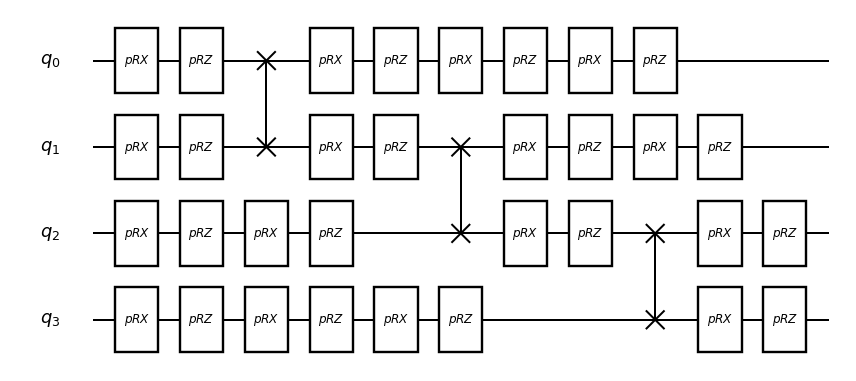

In [7]:
from qulacs import ParametricQuantumCircuit

def generate_circuit(nqubit,cdepth):
        
    qc = ParametricQuantumCircuit(nqubit) # circuito de nqubit qubits

    for d in range(cdepth):
        for i in range(nqubit):
            angle = np.random.rand()*2*np.pi
            qc.add_parametric_RX_gate(i,angle)
            angle = np.random.rand()*2*np.pi
            qc.add_parametric_RZ_gate(i,angle)
        qc.add_SWAP_gate(d,d+1)
    for i in range(nqubit):
            angle = np.random.rand()*2*np.pi
            qc.add_parametric_RX_gate(i,angle)
            angle = np.random.rand()*2*np.pi
            qc.add_parametric_RZ_gate(i,angle)
    
    return qc

qc = generate_circuit(nqubit,cdepth)
circuit_drawer(qc,'mpl')


Podemos acceder a los parámetros iniciales

In [8]:
# Acceder a valores de los parámetros
parameter_count = qc.get_parameter_count()
theta_init = [qc.get_parameter(ind) for ind in range(parameter_count)]
print(f'Initial {parameter_count} parameters: {theta_init}')

def parameters_to_matrix(theta,nqubit,cdepth):
    theta = np.array(theta).reshape(2*(cdepth+1),nqubit).transpose()
    return theta

theta_init_mat = parameters_to_matrix(theta_init,nqubit,cdepth)
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print(f'Initial parameters matrix: \n{theta_init_mat}')
np.set_printoptions()



Initial 32 parameters: [2.4084997716668557, 4.153261838806345, 4.164229013203845, 3.2894740345213145, 6.044913675911709, 2.392021915159164, 4.1443977344339125, 2.941743154763658, 5.512968299853289, 1.2789708500119537, 5.123215079066818, 2.537188836424364, 5.374832004655802, 2.048407357536449, 2.5891510367532806, 2.972198692407316, 2.1570446764006794, 5.131492507421073, 5.150093473010323, 6.02511062681234, 5.359024003374683, 6.04245879556414, 2.155393796941005, 5.490824593698527, 0.1904010565537798, 5.273884339475074, 1.627192183862159, 1.8093053346817378, 4.740670008744777, 4.68641443542324, 4.687061590200057, 2.93987704375696]
Initial parameters matrix: 
[[ 2.41  6.04  5.51  5.37  2.16  5.36  0.19  4.74]
 [ 4.15  2.39  1.28  2.05  5.13  6.04  5.27  4.69]
 [ 4.16  4.14  5.12  2.59  5.15  2.16  1.63  4.69]
 [ 3.29  2.94  2.54  2.97  6.03  5.49  1.81  2.94]]


Podemos definir una función que actualiza los valores de los ángulos en el circuito a partir de una lista de valores.

In [9]:
# Function that updates parameter theta
def set_U_out(theta):

    global qc # qc es una variable global que actualizo
    
    parameter_count = qc.get_parameter_count()

    for i in range(parameter_count):
        qc.set_parameter(i, theta[i])

Queremos maximizar el producto interno de los estados $U_{qc}(\theta)|1  \rangle$ y $|N \rangle$, es decir, $f = | \langle 1| U_{qc}(\theta)| N \rangle |^2 \simeq 1$. Definimos esta fidelidad, usando la función inner product de qulacs.

In [10]:
def calculate_fidelity(theta):
    
    nstate = QuantumState(nqubit) # Estado objetivo
    nstate.set_computational_basis(0b1000) # |N> en la base computacional
    
    state = QuantumState(nqubit) 
    state.set_computational_basis(0b0001) # |1> en la base computacional

    set_U_out(theta)
    #qc = generate_noise_circuit(nqubit,cdepth,theta)
    qc.update_quantum_state(state)
    
    return np.abs(inner_product(state,nstate))

In [11]:
def measured_loss(theta):
    
    nstate = QuantumState(nqubit) # Estado objetivo
    nstate.set_computational_basis(0b1000) # |N> en la base computacional
    
    state = QuantumState(nqubit) 
    state.set_computational_basis(0b0001) # |1> en la base computacional

    set_U_out(theta)
    #qc = generate_noise_circuit(nqubit,cdepth,theta)
    qc.update_quantum_state(state)
    
    z0 = Observable(nqubit)
    z0.add_operator(1.,'Z 0')

    z1 = Observable(nqubit)
    z1.add_operator(1.,'Z 1')

    z2 = Observable(nqubit)
    z2.add_operator(1.,'Z 2')

    z3 = Observable(nqubit)
    z3.add_operator(1.,'Z 3')
    

    L = -z0.get_expectation_value(state) - z1.get_expectation_value(state) - z2.get_expectation_value(state) + z3.get_expectation_value(state)*10

    global cost_history_dict
        
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(L)

    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {L}]")

    return L


In [12]:
print(' Fidelidad con parámetros iniciales: ', calculate_fidelity(theta_init))
print(' Fidelidad con compuertas en 0: ', calculate_fidelity([0 for i in range(parameter_count)]))

 Fidelidad con parámetros iniciales:  0.23331517096859924
 Fidelidad con compuertas en 0:  1.0


Ahora definimos una función a minimizar que almacene la evolución de la minimización en un diccionario.

In [13]:
# Cálculo de función costo
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''    
    global cost_history_dict
    
    L = 1-calculate_fidelity(theta)
    
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(L)

    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {L}]")

    return L


Iters. done: 1 [Current cost: -5.804985500297353]
Iters. done: 2 [Current cost: 2.488972056504786]
Iters. done: 3 [Current cost: -0.519131485483807]
Iters. done: 4 [Current cost: -5.619280220187393]
Iters. done: 5 [Current cost: -6.603731517543818]
Iters. done: 6 [Current cost: -6.354436491852622]
Iters. done: 7 [Current cost: -6.756025888285258]
Iters. done: 8 [Current cost: -6.51620860225126]
Iters. done: 9 [Current cost: -6.4460757247064615]
Iters. done: 10 [Current cost: -7.1859487576145]
Iters. done: 11 [Current cost: -7.3619704228047125]
Iters. done: 12 [Current cost: -11.229465901709485]
Iters. done: 13 [Current cost: -8.967945228413491]
Iters. done: 14 [Current cost: -11.35910213683525]
Iters. done: 15 [Current cost: -11.487943285932108]
Iters. done: 16 [Current cost: -12.202702963199068]
Iters. done: 17 [Current cost: -12.623993721675062]
Iters. done: 18 [Current cost: -12.204816269924063]
Iters. done: 19 [Current cost: -12.58436037223098]
Iters. done: 20 [Current cost: -12.04

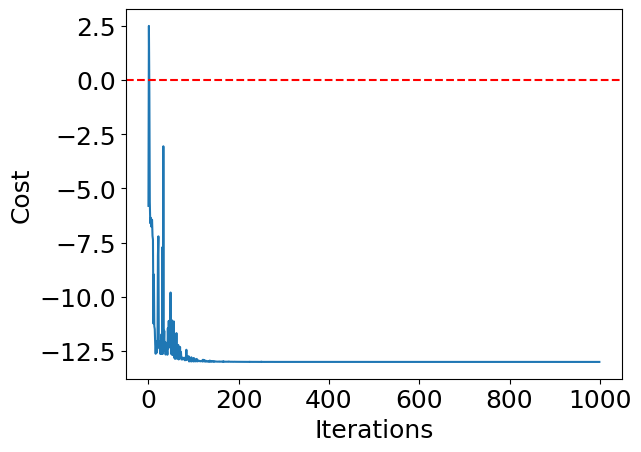

In [14]:
from scipy.optimize import minimize
    
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
bounds = [(0, 2*np.pi) for i in range(parameter_count)]
result = minimize(measured_loss, theta_init, method='cobyla', tol=1e-8, bounds=bounds)
print(result.message)
print(result.fun)
print(result.x/np.pi)

all(cost_history_dict["prev_vector"] == result.x)
cost_history_dict["iters"] == result.nfev
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=0, color='r', linestyle='--', label="Energía objetivo (-1.84)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
#ax.set_yscale("log")
plt.draw()

In [15]:
parameter_count = qc.get_parameter_count()
theta_fin = [qc.get_parameter(ind) for ind in range(parameter_count)]
print(f'Final {parameter_count} parameters: {theta_fin}')


Final 32 parameters: [2.53673177323843, 4.045739025564524, 3.9825336798291473, 3.817119758197085, 5.768370109894987, 3.2938203635778573, 4.238185147180699, 2.756818856764746, 6.256591999660558, 2.8750223414091036, 6.012756831103273, 2.7059932306700567, 6.271910168404007, 3.3292968485631227, 3.60998514682984, 4.045336119931991, 2.1062920505197935, 5.31883994154295, 5.0372437956325316, 6.118218871205952, 5.236406701958231, 5.913549724344648, 1.8730034660301158, 5.5735002273737315, 0.36297952120120247, 5.310124074959258, 1.7225965287676999, 1.5906449446891329, 4.413533457488965, 4.755833743446053, 4.524408906027013, 3.0143947480526423]


Medimos usando los parámetros finales

In [16]:
theta_fin = result.x

def print_results(theta_fin):
    state = QuantumState(nqubit)
    state.set_computational_basis(0b0001)
    target_state = QuantumState(nqubit)
    target_state.set_computational_basis(0b1000)

    print('Initial state vector: ', state.get_vector())
    print('Expectation values for initial state: ')
    measure_exp_vals(state)
    print('Fidelity with initial state: ', np.abs(inner_product(state,target_state)))   
    print('---------------------------------------------------------------------------')
    set_U_out(theta_fin)
    qc.update_quantum_state(state)


    print('Final state vector: ', state.get_vector())

    print('Expectation values for out state: ')
    measure_exp_vals(state)
    print('Fidelity with out state: ', np.abs(inner_product(state,target_state)))   
    print('---------------------------------------------------------------------------')
    print('Final parameters (parameters / pi): ', theta_fin/np.pi)
print_results(theta_fin)


Initial state vector:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Expectation values for initial state: 
 Z_0 =  -1.0
 Z_1 =  1.0
 Z_2 =  1.0
 Z_3 =  1.0
Fidelity with initial state:  0.0
---------------------------------------------------------------------------
Final state vector:  [ 3.62149382e-07+1.16879872e-07j -2.27124029e-13+4.97455933e-13j
 -3.19849962e-13+1.08852940e-13j  4.61023909e-18-8.93693980e-18j
 -8.47747582e-13-3.58335115e-13j  1.17436987e-17+1.42878907e-17j
  2.90497243e-17+3.67464608e-17j -1.67793466e-18-3.33984688e-18j
 -2.72633975e-03+9.99996284e-01j -1.42680789e-06-1.70460180e-07j
 -5.28298304e-07-7.13496842e-07j  1.10636312e-12-6.35195189e-13j
  2.18170939e-07-2.40873182e-06j  3.40155017e-12+7.12608609e-13j
  1.12184820e-12+1.83083956e-12j  3.46274748e-18-1.17595348e-17j]
Expectation values for out state: 
 Z_0 =  0.9999999999958687
 Z_1 =  0.999999999998422
 Z_2 =  0.9999999999882992
 Z_3 = 

Replico simulando theta_fin = [0,0,0,0,0,0, .... ]

In [17]:
theta_fin = [0 for i in range(parameter_count)]
state = QuantumState(nqubit)
state.set_computational_basis(0b0001)
target_state = QuantumState(nqubit)
target_state.set_computational_basis(0b1000)

print('Initial state vector: ', state.get_vector())
print('Expectation values for initial state: ')
measure_exp_vals(state)
print('Fidelity with initial state: ', np.abs(inner_product(state,target_state)))   

set_U_out(theta_fin)

qc.update_quantum_state(state)


print('Final state vector: ', state.get_vector())

print('Expectation values for out state: ')
measure_exp_vals(state)
print('Fidelity with out state: ', np.abs(inner_product(state,target_state)))   



Initial state vector:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Expectation values for initial state: 
 Z_0 =  -1.0
 Z_1 =  1.0
 Z_2 =  1.0
 Z_3 =  1.0
Fidelity with initial state:  0.0
Final state vector:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Expectation values for out state: 
 Z_0 =  1.0
 Z_1 =  1.0
 Z_2 =  1.0
 Z_3 =  -1.0
Fidelity with out state:  1.0


### Extensión a una simulación con ruido

In [18]:
theta_fin = np.array(theta_fin).reshape(nqubit, cdepth)
print(theta_fin)



ValueError: cannot reshape array of size 32 into shape (4,3)

In [ ]:
parameters_list = [[1,1,1,1,1,1,1,1], [2,2,2,2,2,2,2,2],[3,3,3,3,3,3,3,3], [4,4,4,4,4,4,4,4]]
parameters = np.array(parameters_list)

In [ ]:
def noisy_circuit_generation(nqubit,cdepth,parameters):
        
    qc = ParametricQuantumCircuit(nqubit) # circuito de nqubit qubits

    for d in range(cdepth):
        for i in range(nqubit):
            print(i,d)
            angle = parameters[i,2*d]
            qc.add_parametric_RX_gate(i,angle)
            angle = parameters[i,2*d+1]
            qc.add_parametric_RZ_gate(i,angle)
        qc.add_SWAP_gate(d,d+1)
    for i in range(nqubit):
            angle = parameters[i,2*d]
            qc.add_parametric_RX_gate(i,angle)
            angle = parameters[i,2*d+1]
            qc.add_parametric_RZ_gate(i,angle)

    return qc

circuit_drawer(noisy_circuit_generation(nqubit,cdepth,parameters),'mpl')
# Acceder a valores de los parámetros
parameter_count = qc.get_parameter_count()
theta_init = [qc.get_parameter(ind) for ind in range(parameter_count)]
print(f'Initial {parameter_count} parameters: {theta_init}')

def parameters_to_matrix(theta,nqubit,cdepth):
    theta = np.array(theta).reshape(2*(cdepth+1),nqubit).transpose()
    return theta

theta_init = parameters_to_matrix(theta_init,nqubit,cdepth)
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print(f'Initial parameters matrix: \n{theta_init}')
np.set_printoptions()


0 0
1 0
2 0
3 0
0 1
1 1
2 1
3 1
0 2
1 2
2 2
3 2
Initial 32 parameters: [2.050100715651215, 1.6998270423398876, 4.75671163989429, 1.1193240222256775, 0.20386795617748735, 0.7938814863683822, 4.981807460642435, 3.029049011461471, 4.136464784053531, 6.1237884740606265, 3.47952625145746, 2.6082108550860545, 5.1216634778829215, 3.7005898128920096, 2.1805551460116477, 3.2102478777196772, 0.10576077953845996, 3.5001098176469876, 4.337033904543613, 4.440679940236604, 1.7265129707681521, 1.4022335887716937, 5.1549747226209, 1.5275412874175573, 6.236791014786782, 0.3378498226656087, 0.7218258314397703, 6.1166503169239945, 1.0172130398455403, 4.679086337144484, 4.978975544767994, 3.697369212521052]
Initial parameters matrix: 
[[ 2.05  0.20  4.14  5.12  0.11  1.73  6.24  1.02]
 [ 1.70  0.79  6.12  3.70  3.50  1.40  0.34  4.68]
 [ 4.76  4.98  3.48  2.18  4.34  5.15  0.72  4.98]
 [ 1.12  3.03  2.61  3.21  4.44  1.53  6.12  3.70]]
